In [1]:
!pip install geopandas
!pip install rioxarray

import numpy as np
import matplotlib.pyplot as plt
from math import *
import cv2
import geopandas as gpd
from google.colab import drive
import os
import pickle
import rioxarray
from pyproj import CRS
import fiona

drive.mount("/content/drive")
os.chdir('./drive/MyDrive/DREAMS - Zhiang/Projects/Rock Traits/data')
print(os.listdir())

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 25.6 MB/s 
     |████████████████████████████████| 15.4 MB 31.6 MB/s 
     |████████████████████████████████| 46 kB 2.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3 MB 71.6 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.9.0-py3-none-any.whl size=54395 sha256=c1fcd1212d743d1877e55a85eae2af627c11b8a6f59b95d7220dae77e34c77e5
  Stored in directory: /root/.cache/pip/wheels/f2/0d/f2/29da7ed804b71eb1317c3683b373f59d7c0c4c501117f2b144
Successfully built rioxarray
Mounted at /content/drive
['README', 'C3_sk.jpg', 'registered_instances_c3_rgbd1.pickle', 'registered_instances_c3_rgbd1_refined.pickle', 'registered_instances_c3_rgbd1_refined_update.pickle', 'C3.tif', 'c3_rocks', 'registered_instances_c3_rgbd1_update.pickle', 'registered_instances_c3_rgbd1_

In [2]:
with open('registered_instances_c3_rgbd1_refined_update.pickle' , 'rb') as f0:
  instances = pickle.load(f0)

print(len(instances))

36698


## contour analysis

In [ ]:
# contour analysis
def create_bool_mask(mask, size):
  mask_ = np.zeros(size)
  for y, x in mask:
    if (y < size[0]) & (x < size[1]):
      mask_[y, x] = 1
  return mask_

for instance in instances:
  bb = instance['bb']  # origin: upper left; [north, west, south, east]; north < south; west < east
  mask = instance['mask']
  top_left = bb[:2]
  mask = mask - top_left
  mask = create_bool_mask(mask, bb[2:] - bb[:2])
  #_, contours, _ = cv2.findContours(mask.astype(np.uint8).copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)  # python2
  contours, _ = cv2.findContours(mask.astype(np.uint8).copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # python3
  areas = [cv2.contourArea(cnt) for cnt in contours]
  if len(areas) == 0:
    instance['contour'] = np.zeros((1, 2))
    instance['major_length'] = 0
    instance['minor_length'] = 0
    instance['eccentricity'] = 0
    instance['angle'] = 0
    instance['size'] = 0
    continue
  id = np.argmax(areas)
  cnt = contours[id].reshape(-1, 2)
  instance['contour'] = np.array((bb[1] + cnt[:,0], bb[0] + cnt[:,1])).transpose()
  size = areas[id]
  if cnt.shape[0] >= 5:
    ellipse = cv2.fitEllipse(cnt)
    (x, y), (MA, ma), angle = ellipse
    a = ma / 2
    b = MA / 2
    instance['major_length'] = ma
    instance['minor_length'] = MA
    eccentricity = sqrt(pow(a, 2) - pow(b, 2))
    eccentricity = round(eccentricity / a, 2)
    instance['eccentricity'] = eccentricity
    instance['angle'] = angle
    instance['size'] = size
  else:
    instance['major_length'] = 0
    instance['minor_length'] = 0
    instance['eccentricity'] = 0
    instance['angle'] = 0
    instance['size'] = 0

## create shapefile

In [ ]:
# open a tif raster and read attributes 
c3 = rioxarray.open_rasterio("C3.tif")

In [ ]:
# attributes
print(c3.rio.crs)
print(c3.rio.nodata)
print(c3.rio.bounds())
print(c3.rio.width)
print(c3.rio.height)
print(c3.rio.resolution())

EPSG:32611
None
(372333.78378156334, 4145784.9609071277, 372544.16285686305, 4146294.8455599267)
10589
25664
(0.019867699999973145, -0.019867699999960856)


In [ ]:
epsg = c3.rio.crs.to_epsg()
crs = CRS(epsg)
crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
def pixel2coord(pixel):
  h_size, v_size = c3.rio.resolution()
  h_start, _, _, v_start= c3.rio.bounds()
  return [h_start + pixel[0]*h_size, v_start + pixel[1]*v_size]

In [ ]:
# create shapefile
# 1. define schema
schema = {
    'geometry':'Polygon',
    'properties':[('name','str'), ['size', 'int'], ['major_length', 'float'], ['minor_length', 'float'], ['eccentricity', 'float'], ['angle', 'float']]
}

# 2. open a write file
polyShp = fiona.open('c3_rocks/filtered_v1/rockPoly_filtered_v1.shp', mode='w', driver='ESRI Shapefile', schema = schema, crs = c3.rio.crs)

# 3. add polygons to file
for instance in instances:
  contour = instance['contour'].reshape(-1, 2).tolist()
  crs_contour = [pixel2coord(pixel) for pixel in contour]
  if len(crs_contour) < 3:
    print('x')
    continue
  rowDict = {'geometry' : {'type':'Polygon', 'coordinates': [crs_contour]}, 'properties': {'name': 'rock', 'size': instance['size'], 'major_length': instance['major_length'], 'minor_length': instance['minor_length'], 'eccentricity': instance['eccentricity'], 'angle': instance['angle']}}
  polyShp.write(rowDict)

# 4. write file
polyShp.close()

NameError: ignored

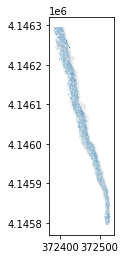

In [ ]:
c3_shape = gpd.read_file("c3_rocks/filtered_v1/rockPoly_filtered_v1.shp")
c3_shape.plot()